<a href="https://colab.research.google.com/github/divyanshuraj6815/QUANTUM-ML/blob/main/Quantum_Machine_Learning_(Iris_Dataset).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pennylane >> /dev/null
!pip install strawberryfields >> /dev/null
!pip install PennyLane-SF >> /dev/null

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers

import pennylane as qml
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler

In [3]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data

--2022-11-06 23:17:35--  https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4551 (4.4K) [application/x-httpd-php]
Saving to: ‘iris.data’

iris.data           100%[===================>]   4.44K  --.-KB/s    in 0s      

2022-11-06 23:17:35 (106 MB/s) - ‘iris.data’ saved [4551/4551]



In [2]:
import pandas as pd

In [3]:
df = pd.read_csv ('iris.data', names = ['f1', 'f2', 'f3', 'f4', 'class'], header = None)

In [4]:
df

,f1,f2,f3,f4,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


In [5]:
Y = df['class']
X = df.drop(['class'], axis=1)
print("Shape of Input  features: {}".format(X.shape))
print("Shape of Output features: {}".format(Y.shape))

Shape of Input  features: (150, 4)
Shape of Output features: (150,)


In [6]:
Y.value_counts()

Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: class, dtype: int64

In [7]:
lbl_clf = LabelEncoder()
Y_encoded = lbl_clf.fit_transform(Y)

In [9]:
def one_hot(labels):  
       
    depth =  4**2                       # 3 classes + 13 zeros for padding
    indices = labels.astype(np.int64)    
    one_hot_labels = np.eye(depth)[indices].astype(np.float64) 
    
    return one_hot_labels


Y_train = one_hot(Y_encoded)

In [10]:
x_train, x_test, y_train, y_test = train_test_split(X, Y_train, test_size=0.05, random_state=42, stratify=Y_encoded, shuffle=True)

print("Training Input shape\t: {}".format(x_train.shape))
print("Testing Input shape\t: {}".format(x_test.shape))
print("Training Output shape\t: {}".format(y_train.shape))
print("Testing Output shape\t: {}".format(y_test.shape))

Training Input shape	: (142, 4)
Testing Input shape	: (8, 4)
Training Output shape	: (142, 16)
Testing Output shape	: (8, 16)


In [11]:
keras.backend.set_floatx('float64')

model = keras.models.Sequential([
                                 layers.Dense(14, activation ="elu", input_shape=(4,)),
                                 layers.Dense(14, activation ="elu") 
                                ])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 14)                70        
                                                                 
 dense_1 (Dense)             (None, 14)                210       
                                                                 
Total params: 280
Trainable params: 280
Non-trainable params: 0
_________________________________________________________________


In [12]:
def data_encoding(x):
    qml.Squeezing(x[3], x[4], wires=0)
    qml.Squeezing(x[9], x[10], wires=1)
    
    qml.Beamsplitter(x[5], x[6], wires=[0,1])
    
    qml.Rotation(x[7], wires=0)
    qml.Rotation(x[8], wires=1)
    
    qml.Displacement(x[1], x[2], wires=0)
    qml.Displacement(x[11], x[12], wires=1)
    
    qml.Kerr(x[0], wires=0)
    qml.Kerr(x[13], wires=1)

In [13]:
def qnn_layer(v):
    # Interferometer 1
    qml.Beamsplitter(v[0], v[1], wires=[0,1])
    qml.Rotation(v[2], wires=0)
    qml.Rotation(v[3], wires=1)
    
    # Squeezers
    qml.Squeezing(v[4], 0.0, wires=0)
    qml.Squeezing(v[5], 0.0, wires=1)
    
    # Interferometer 2
    qml.Beamsplitter(v[6], v[7], wires=[0,1])
    qml.Rotation(v[8], wires=0)
    qml.Rotation(v[9], wires=1)
    
    # Bias addition
    qml.Displacement(v[10], 0.0, wires=0)
    qml.Displacement(v[11], 0.0, wires=1)
    
    # Non-linear activation function
    qml.Kerr(v[12], wires=0)
    qml.Kerr(v[13], wires=1)

In [14]:
def init_weights(layers, modes, active_sd=0.0001, passive_sd=0.1):
    
    # Number of interferometer parameters: beamsplitter + 2 rotations
    M = 2 + 1 + 1  

    int1_weights = tf.random.normal(shape=[layers, M], stddev=passive_sd)
    s_weights = tf.random.normal(shape=[layers, modes], stddev=active_sd)
    int2_weights = tf.random.normal(shape=[layers, M], stddev=passive_sd)
    dr_weights = tf.random.normal(shape=[layers, modes], stddev=active_sd)
    k_weights = tf.random.normal(shape=[layers, modes], stddev=active_sd)

    weights = tf.concat([int1_weights, s_weights, int2_weights, dr_weights, k_weights], axis=1)
    weights = tf.Variable(weights)

    return weights

In [15]:
num_modes = 2
cutoff_dim = 4

# select a devide 
dev = qml.device("strawberryfields.fock", wires=num_modes, cutoff_dim=cutoff_dim) 

@qml.qnode(dev, interface="tf")
def quantum_nn(inputs, var):
    # Encode input x into quantum state
    data_encoding(inputs)

    # iterative quantum layers
    for v in var:
        qnn_layer(v)

    return qml.probs(wires=[0, 1])

In [16]:
num_layers = 4

# initialize weights for quantum layers
weigths = init_weights(num_layers, num_modes)

# convert the quantum layer to a Keras layer
shape_tup = weigths.shape
weight_shapes = {'var': shape_tup}
qlayer = qml.qnn.KerasLayer(quantum_nn, weight_shapes, output_dim=4)

# add to the classical sequential model
model.add(qlayer)

In [17]:
opt = keras.optimizers.SGD(lr = 0.002)
model.compile(opt, loss = 'categorical_crossentropy', metrics =['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.


In [18]:
hybrid = model.fit(x_train, 
                   y_train,
                   epochs = 30,
                   batch_size = 64,
                   shuffle = True, 
                   validation_data = (x_test, y_test))

Epoch 1/30
3/3 [==============================] - 86s 23s/step - loss: 1.8191 - accuracy: 0.3099 - val_loss: 1.4752 - val_accuracy: 0.6250
Epoch 2/30
3/3 [==============================] - 80s 22s/step - loss: 1.3798 - accuracy: 0.4930 - val_loss: 1.1893 - val_accuracy: 0.6250
Epoch 3/30
3/3 [==============================] - 80s 22s/step - loss: 1.3606 - accuracy: 0.5845 - val_loss: 2.6340 - val_accuracy: 0.5000
Epoch 4/30
3/3 [==============================] - 81s 22s/step - loss: 1.4879 - accuracy: 0.6268 - val_loss: 1.1999 - val_accuracy: 0.5000
Epoch 5/30
3/3 [==============================] - 81s 22s/step - loss: 1.0355 - accuracy: 0.8239 - val_loss: 0.9362 - val_accuracy: 0.7500
Epoch 6/30
3/3 [==============================] - 80s 22s/step - loss: 0.9389 - accuracy: 0.8451 - val_loss: 0.8965 - val_accuracy: 0.7500
Epoch 7/30
3/3 [==============================] - 81s 22s/step - loss: 0.9063 - accuracy: 0.8028 - val_loss: 0.7523 - val_accuracy: 0.8750
Epoch 8/30
3/3 [===========

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 14)                70        
                                                                 
 dense_1 (Dense)             (None, 14)                210       
                                                                 
 keras_layer (KerasLayer)    (None, 4)                 56        
                                                                 
Total params: 336
Trainable params: 336
Non-trainable params: 0
_________________________________________________________________


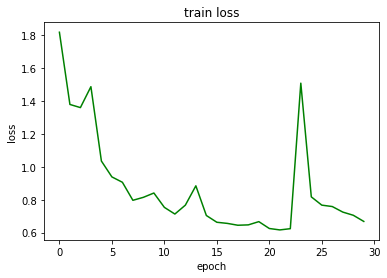

In [26]:
# ===================================================================================
#                                  Loss History Plot
# ===================================================================================

plt.title('train loss')
plt.plot(hybrid.history['loss'], '-g')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

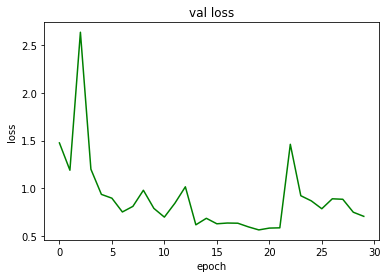

In [27]:
# ===================================================================================
#                                  Loss History Plot
# ===================================================================================

plt.title('val loss')
plt.plot(hybrid.history['val_loss'], '-g')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

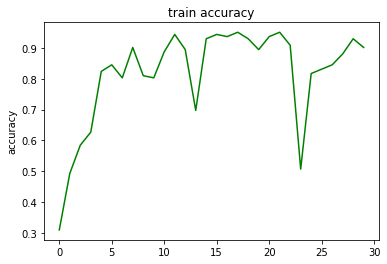

In [29]:
# ===================================================================================
#                                Accuracy History Plot
# ===================================================================================

plt.title('train accuracy')
plt.plot(hybrid.history['accuracy'], '-g')
plt.ylabel('accuracy')
plt.show()

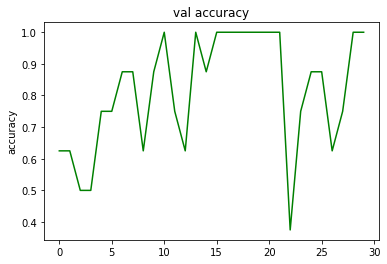

In [28]:
# ===================================================================================
#                                Accuracy History Plot
# ===================================================================================

plt.title('val accuracy')
plt.plot(hybrid.history['val_accuracy'], '-g')
plt.ylabel('accuracy')
plt.show()